< [Part 3: Audio Features](spotify_3_audio_features.ipynb) | [Main](index.ipynb) | [Part 5: Classifier and Recommender](spotify_5_classifier_and_recommender.ipynb) >

---

# Social Features: Popularity and Followers

Before we move on to building a dataset classifier, let's have a look at Spotify's different popularity metrics.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import bokeh.plotting as bkplt
import bokeh as bk
from bokeh.io import output_notebook
import sklearn
from sklearn.linear_model import LinearRegression

#Collection of functions created in previous notebook
from groupby_lists import *
from violin_midcurve import *
from extremes_plot import *
from decade_violinplot import *
from bar_violin import *
from smooth_scatterplot import *

%matplotlib inline

#Custom seaborn/matplotlib settings
rc = {'axes.edgecolor': '0', 'axes.labelcolor': '0', 'grid.color': '0', 
      'figure.figsize': [6, 6], 'lines.linewidth': '2', 'text.color': '0', 
      'xtick.color': '0', 'ytick.color': '0' }
sns.set(context='notebook', style='white', font_scale=1.5, rc=rc)

pd.options.display.max_columns = 50

red = (1,0,0)
blue = (0,.475,1) #Same relative luminance (linearized) as primary red (approx)
purple = (.736,.343,.736) #Linearized average between above red and blue

#Bokeh inline Jupyter plots
output_notebook()

df = pd.read_hdf('./data/df.h5', 'main')
by_genre = groupby_lists(df,'genres','genre')

Loading BokehJS ...

# Popularity-related Features

From the Spotify API [documentation](https://developer.spotify.com/web-api/object-model/):

>**(track) popularity** (integer): 
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

>Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

>**(artist) popularity** (integer):
The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist's popularity is calculated from the popularity of all the artist's tracks.

>**(album) popularity** (integer): The popularity of the album. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated from the popularity of the album's individual tracks.

>**(artist) total followers** (integer): The artist's total number of followers.

We'll visualize these using our `violin_midcurve` function from the [previous notebook](spotify_3_audio_features.ipynb).

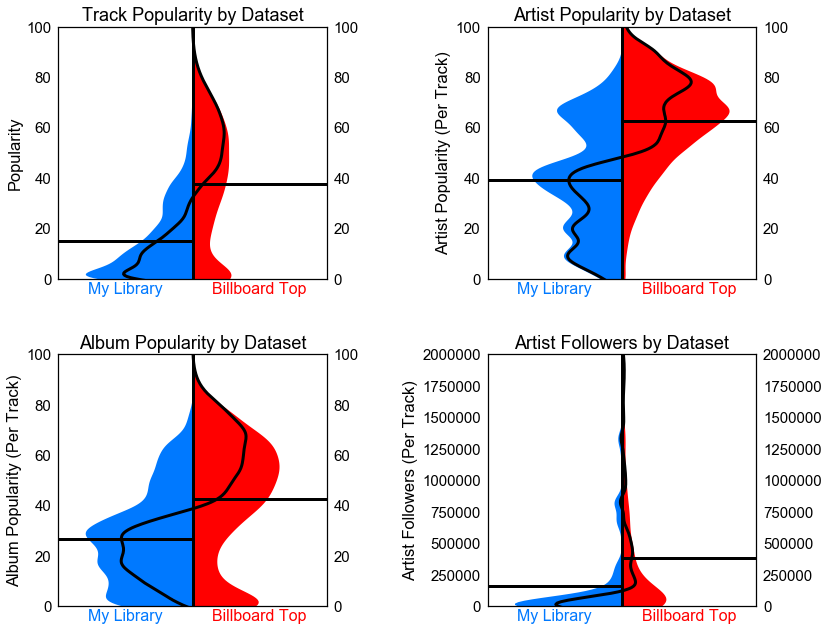

In [2]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12.5,11.5))
violin_midcurve( 'popularity', df, ylim=[0,100], ax=ax1 )
violin_midcurve( 'popularity_artist', df,
                y_label='Artist Popularity (Per Track)', 
                title='Artist Popularity by Dataset', ylim=[0,100], ax=ax2 )
violin_midcurve( 'popularity_album', df, y_label='Album Popularity (Per Track)',
                title='Album Popularity by Dataset', ylim=[0,100], ax=ax3 )
violin_midcurve( 'num_followers', df[df.num_followers<2e6], 
                y_label='Artist Followers (Per Track)', 
                title='Artist Followers by Dataset', ylim=[0,2e6], ax=ax4 );
plt.subplots_adjust(wspace=.6, hspace=.3, top=.70, bottom=0)

As one might expect, Billboard hits have a higher average popularity than tracks in my library, as hits are &mdash; by definition &mdash; *popular*. Since artist and album popularity are calculated from larger sets of tracks, the three popularity distributions are not identical.

One interesting thing to notice is the high density of very low popularity tracks, in terms of both track and album popularity. More on this shortly.

Focusing on an artist's total number of followers, we can see that the distribution has a very long tail, corresponding to a small number of artists with a very high number of followers.

Let's see how the popularity of Billboard hits varies over the decades, using our `decade_violinplot` from the [previous notebook](spotify_3_audio_features.ipynb).

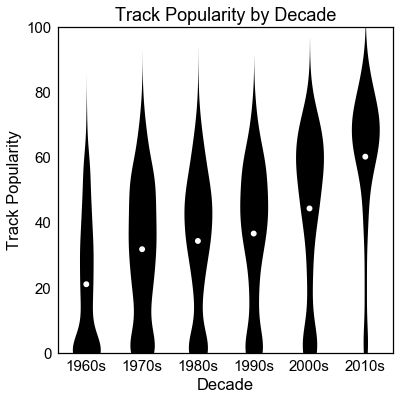

In [3]:
p = decade_violinplot( df, 'popularity', ylim=[0,100], 
                      ylabel='Track Popularity', 
                      title='Track Popularity by Decade' )

Recall from the quote above:
>Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.

So, despite the tracks all being the most popular during their respective decades, Spotify users tend to listen to more recently released tracks.

---

Again, we also see a high density of very low popularity tracks. Let's investigate this. 

First, another excerpt from the above description of track popularity:
>Duplicate tracks (e.g. the same track from a single and an album) are rated independently.

So, for example, if a given track has many plays, but spread out over different releases of the track (album, single, compilations), the popularity of any one of those tracks will be relatively low. When scraping the Billboard hit tracks, I made no attempt to find the most popular release of a given track. This means it's entirely possible that many of the tracks in my Billboard dataset are versions with a very low play count.

In fact, a significant fraction of the tracks have **zero** popularity:

In [4]:
#Number of tracks in the Billboard dataset with zero popularity
df[ (df.ds=='top') & (df.popularity==0) ].shape[0]

598

That's around 10% of the Billboard dataset! This could be partially ameliorated by actively searching for the most popular variant of each track. However, this would pose additional challenges, and would not eliminate the problem entirely.

## Popularity versus Number of Followers

Let's see how an artist's popularity relates to their total number of followers. First, let's use our `extreme_artist_plot` and `extreme_genres_plot` from the [previous notebook](spotify_3_audio_features.ipynb) on both artist popularity and number of followers.

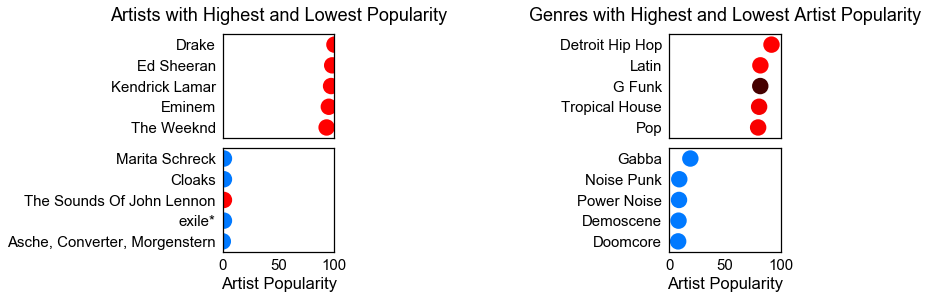

In [5]:
col = 'popularity_artist'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
xlabel = 'Artist Popularity'
title='Artists with Highest and Lowest Popularity'
p = extreme_artists_plot(df, col, xlim=[0,100], axes=(ax1,ax3),
                         title=title, xlabel=xlabel)
title='Genres with Highest and Lowest Artist Popularity'
p = extreme_genres_plot(by_genre, col, xlim=[0,100], axes=(ax2,ax4),
                        title=title, xlabel=xlabel)
plt.subplots_adjust(wspace=3)

The most popular artists (and genres) are familiar pop stars (and their corresponding genres), all from the Billboard dataset. 

The least popular artists all have a popularity equal to (or close to) zero, so we are likely seeing a random sample from the zero-popularity tail of artists.

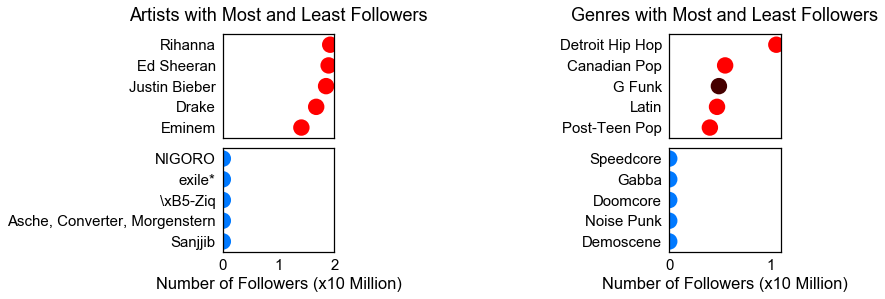

In [6]:
col = 'num_followers'
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,4))
xlabel = 'Number of Followers (x10 Million)'
title = 'Artists with Most and Least Followers'
p = extreme_artists_plot(df, col, xlim=[0,2.0e7], axes=(ax1,ax3), 
                         xlabel=xlabel, title=title)
title = 'Genres with Most and Least Followers'
p = extreme_genres_plot(by_genre, col, xlim=[0,1.1e7], axes=(ax2,ax4), 
                        xlabel=xlabel, title=title)
plt.subplots_adjust(wspace=3)

for ax in [ax1,ax2,ax3,ax4]:
    ax.get_xaxis().get_offset_text().set_visible(False)


The set of artists with the most followers looks similar to the set of most popular artists, but they are far from identical. We even see a difference in rank, with Drake being a "more popular" artist than Rihanna, but having fewer followers.

---

We can directly visualize the relationship between an artist's popularity and number of followers by using the `smooth_scatterplot` function that we defined in the [previous notebook](spotify_3_audio_features.ipynb).

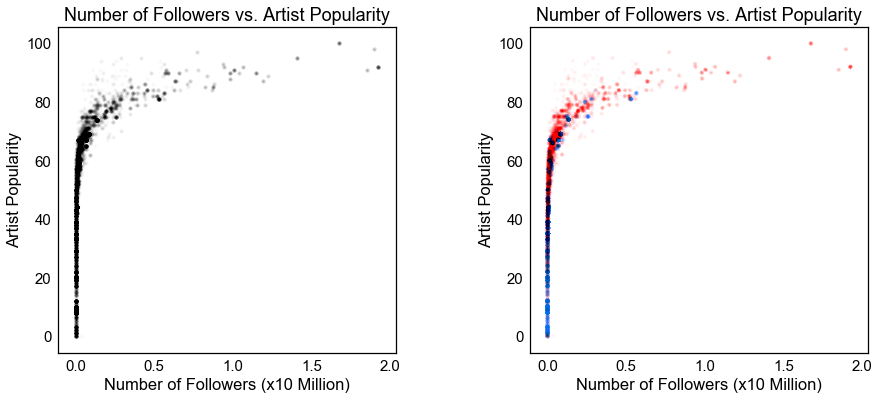

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
xlabel = 'Number of Followers (x10 Million)'
ylabel = 'Artist Popularity'
title = 'Number of Followers vs. Artist Popularity'
p = smooth_scatterplot(df, 'num_followers', 'popularity_artist', color=False, 
                       alpha=.008, ax=ax1, xlabel=xlabel, ylabel=ylabel,
                       title=title)
p = smooth_scatterplot(df, 'num_followers', 'popularity_artist', color=True, 
                       alpha=.008, ax=ax2, xlabel=xlabel, ylabel=ylabel,
                       title=title)
plt.subplots_adjust(wspace=.4)

#Remove exponent on x axes.
ax1.get_xaxis().get_offset_text().set_visible(False)
ax2.get_xaxis().get_offset_text().set_visible(False)

This looks suspiciously like an *exponential* relationship. Let's make a lin-log plot by applying $\log$ to the number of followers.

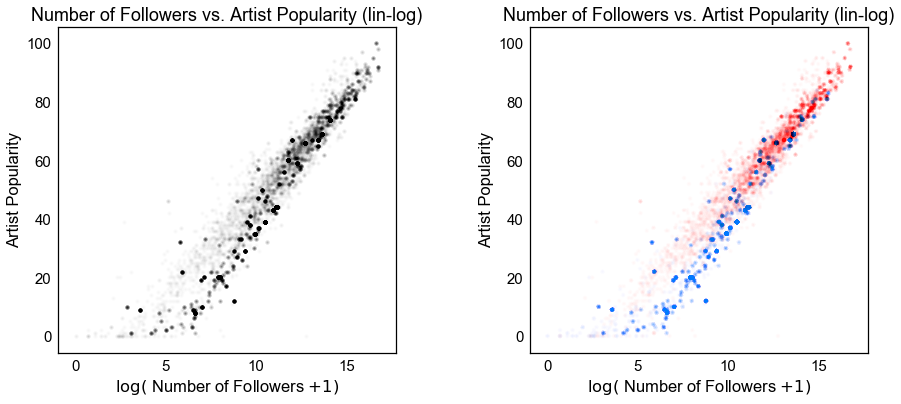

In [8]:
df_temp = df[['popularity_artist','num_followers','ds']].copy()
df_temp['log_followers'] = np.log(df_temp.num_followers+1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14.5,6))
xlabel = r'$\log( $ Number of Followers $+1 )$'
ylabel = 'Artist Popularity'
title = 'Number of Followers vs. Artist Popularity (lin-log)'
p = smooth_scatterplot(df_temp, 'log_followers', 'popularity_artist',
                       color=False, alpha=.008, ax=ax1, xlabel=xlabel, 
                       ylabel=ylabel, title=title)
p = smooth_scatterplot(df_temp, 'log_followers', 'popularity_artist', 
                       color=True, alpha=.008, ax=ax2, xlabel=xlabel, 
                       ylabel=ylabel, title=title)
plt.subplots_adjust(wspace=.4)

This looks very linear to the naked eye, further suggesting an exponential relationship between an artist's popularity and their number of followers. 

Since I'm plotting individual tracks rather than artists, the number of tracks from a given artist is visible here as well. The darker, sparser **blue** peaks indicate that my library has *fewer artists*, each with a *large number of tracks*, whereas the more diffuse density of **red** indicates a *large number of artists* in the Billboard dataset, each with only a *few tracks*.

We can also see that tracks from my library tend to live on the lower-right edge of this streak of datapoints. More on that shortly.

---

Before speculating further, let's verify this exponential relationship in a slightly more objective way. We'll do so by performing **linear regression** on this lin-log transformed data. Each *artist* will be treated as a datapoint (rather than each *track*), so each artist will contribute equally.

We'll perform our linear regression using scikit-learn. See the comments in the cell below for implementation details.

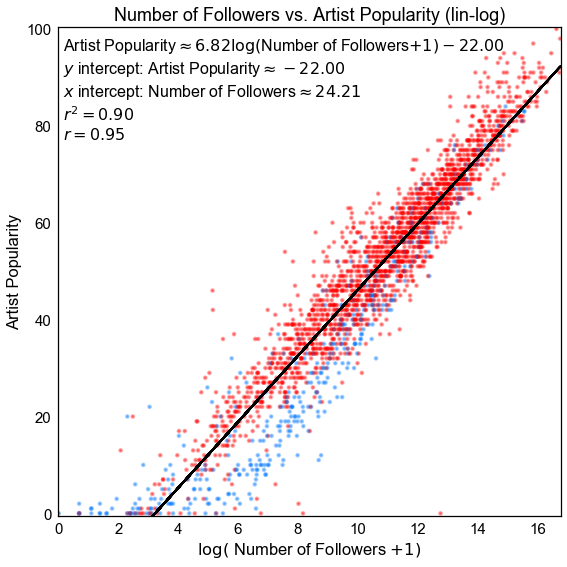

In [9]:
#Construct another dataframe with log('num_followers'+1) column
df_temp = df[['name_artist','popularity_artist','num_followers','ds']].copy()
df_temp['log_followers'] = np.log(df_temp.num_followers+1)

#Group together tracks by the same artist. Use the first row of each group to
#determine what dataset to associate an artist with (since we almost never see
#the same artist in both datasets).
df_temp = df_temp.groupby('name_artist')[
    ['log_followers','popularity_artist','ds'] ].first().reset_index()

#Initialize a LinearRegression model, fit it to the datapoints
linreg = LinearRegression(fit_intercept=True)
linreg.fit(df_temp.log_followers[:, np.newaxis], df_temp.popularity_artist)

#Predict a regression line (use original training inputs for simplicity)
df_temp['popularity_artist_pred'] = linreg.predict(
    df_temp.log_followers[:, np.newaxis] )

#Scatterplot with formatting
plt.figure(figsize=(9,9))
xlabel = r'$\log( $ Number of Followers $+1 )$'
ylabel = 'Artist Popularity'
title = 'Number of Followers vs. Artist Popularity (lin-log)'
p = smooth_scatterplot(df_temp, 'log_followers', 'popularity_artist', 
                       color=True, alpha=.2, xlabel=xlabel, 
                       ylabel=ylabel, title=title)

#Add regression line
p.plot(df_temp.log_followers, df_temp.popularity_artist_pred, color=(0,0,0), 
       lw=2);

#Snug scaling
p.set_ylim( [ -0.5, 100.5 ] )
p.set_xlim( [ df_temp.log_followers.min(), 
             df_temp.log_followers.max() ] );

#Construct various quantities to display
slope = linreg.coef_[0]
y_intercept = linreg.intercept_
r_squared = linreg.score(df_temp.log_followers[:, np.newaxis], 
                         df_temp.popularity_artist)
#Could also square this for r_squared.
r = np.corrcoef(x=df_temp.log_followers, y=df_temp.popularity_artist)[0, 1]

#Since linear regression is on lin-log data, need to calculate intercepts in
#original (lin-lin) space.
#First, x intercept in the lin-log space:
logx_intercept = -y_intercept/slope
#Transform back to linear
x_intercept = np.e**(logx_intercept) - 1

#Draw the above quantities
label = ( 'Artist Popularity' 
          + r'$ \approx {:1.2f}\log( $Number of Followers$+1 ) {:1.2f}$'.
          format(slope,y_intercept)
          + '\n$y$ intercept: Artist Popularity' + r'$ \approx{:1.2f}$'.
          format(y_intercept)
          + '\n$x$ intercept: Number of Followers' + r'$ \approx{:1.2f}$'.
          format(x_intercept)
          + '\n$r^2 = {:1.2f}$'.format(r_squared)
          + '\n$r = {:1.2f}$'.format(r) )
plt.text(.15,99, label, fontsize=16, va='top');

Here, I've plotted the color-coded artists as well as a linear regression line. On the upper left, I've shown the equation for the regression line. Ive also shown the $y$ and $x$ intercepts (in the original, linear space), as well as the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) ($r^2$) and [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) ($r$).

- Since $\log(x+1)=0$ when $x=0$, the $y$-intercept is the same in lin-log and linear space. Since the $y$-intercept occurs where artist popularity is equal to $-22$, we might naively expect artists with zero followers to have a popularity of $-22$ *on average*. Obviously, a negative popularity is not possible, and this linear relationship breaks down for such popularity values. Restricting to *acceptable* popularity values, we may instead expect **artists with no followers to tend to have a popularity of zero**, which is true for our dataset.

- The $x$-intercept in log-lin space is the number of followers such that
$$6.82 \log( \text{ Number of Followers}+1 ) - 22 = 0.$$
Solving for number of followers gives us an $x$-intercept at approximately $24.21$ followers. This indicates that &mdash; *on average* &mdash; **artists with zero popularity will have around $24$ followers**. This is visible on our plot as an $x$-intercept at $\log(24.21+1)\approx3.2$

- In linear regression, the coefficient of determination and Pearson correlation coefficient contain the same information (up to a sign). In both cases, they tell us the degree to which there is a linear relationship between two variables, but nothing about e.g. the slope of this relationship ($r$ does tell us the *sign* of the slope). Interpretation of the size of $r$ is ultimately subjective, but our value of $r=0.95$ is "very close" to the maximum ($1$) that we would see in the case of a *perfect* fit. This suggests a strong linear relationship between the (lin-log transformed) variables, which matches our visual intuition.

---

Again, we see a tendency for datapoints from my library (**blue**) to live just *below* the regression line. In order to investigate this a bit better, let's plot the **residuals** (or "error") from our linear regression. That is, we will subtract off the regression line in order to show how the datapoints deviate from this linear trend. This can also highlight any additional non-linear trends in the (lin-log) data.

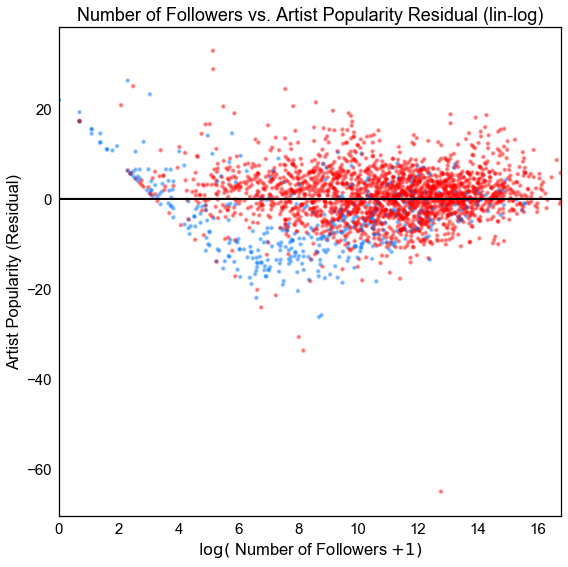

In [10]:
#Calculate deviation from predicted (residual)
df_temp['popularity_artist_residual'] = (df_temp.popularity_artist - 
                                      df_temp.popularity_artist_pred)

#Scatter plot
plt.figure(figsize=(9,9))
xlabel = r'$\log( $ Number of Followers $+1 )$'
ylabel = 'Artist Popularity (Residual)'
title = 'Number of Followers vs. Artist Popularity Residual (lin-log)'
p = smooth_scatterplot(df_temp, 'log_followers', 'popularity_artist_residual', 
                       color=True, alpha=.2, xlabel=xlabel, 
                       ylabel=ylabel, title=title)

#Regression line (now a constant)
p.plot(df_temp.log_followers, df_temp.popularity_artist_pred*0, color=(0,0,0), 
       lw=2);
p.set_xlim( [ df_temp.log_followers.min(), 
             df_temp.log_followers.max() ] );

First, there is no (obvious) trend in the residuals, which may further support our use of linear regression on the (lin-log) datapoints.

We can see here more clearly than ever that for a given number of followers, artists from my dataset have a lower popularity than the linear regression model would predict. In other words, the blue datapoints have a tendency to live below the regression line (negative residual).

---

Generally speaking, artists with a positive popularity residual get *more plays* than we would expect *given their number of followers*. Equivalently, they have *less followers* than we'd expect, *given their popularity*. This could be, for example, due to an artist being a "[one-hit wonder](https://en.wikipedia.org/wiki/One-hit_wonder)." Such an artist may have a single track that is played very often (contributing to high popularity), yet there is little interest in the artist's other output, thus giving a low follower count. A popular artist may also have a small number of followers if they've produced no new music for a long period of time, so older artists may tend to have a larger popularity residual.

Conversely, artists with a *negative* popularity residual get *less plays* than other artists with the *same number of followers*, and they have *more followers* than other artists with the *same popularity*. One possible cause for a negative popularity residual may be that an artist has a *large fanbase* (large number of followers), but few (if any) tracks that are actually *available to play* on Spotify (low playcount). Perhaps this could be part of a measure of [cult following](https://en.wikipedia.org/wiki/Cult_following).

---

Applying these interpretations to the plot above, we might conclude that Billboard hit artists have more of a tendency to be one-hit wonders than artists from my dataset, which seems reasonable. We might also conclude that artists from my library tend to have less tracks available for streaming, given the size of their fanbase. This lines up with my personal experience, having struggled to find streamable tracks from many of my favorite artists, but still "following" them. 

Lets see if our `extreme_artists_plot` can help to elucidate these phenomena.

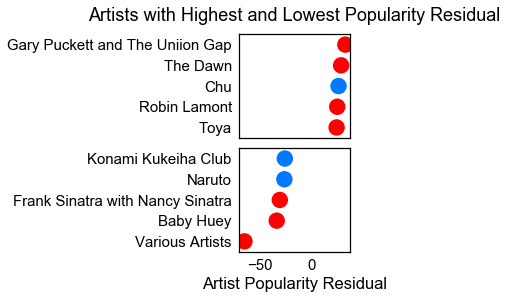

In [11]:
p = extreme_artists_plot(df_temp, 'popularity_artist_residual', min_tracks=0,
                title='Artists with Highest and Lowest Popularity Residual',
                xlabel='Artist Popularity Residual')

Starting with the top artists, The Dawn, Robin Lamont, and Toya all have a *single* Billboard hit, and Chu produced the *Miko Miko Nurse* theme, which went viral on the internet in the early 2000s. This supports our "one-hit wonder" theory.
Gary Puckett and the Uniion Gap [sic] has five Billboard hits, four of which are still quite popular. Examining their artist profile shows a sharp drop in popularity outside of these hits, thus suggesting that the artist is perhaps a "*four*-hit wonder."

Moving to the bottom artists, Konami Kukeiha Club is a video game sountrack studio responsible for producing soundtracks to games such as the popular Silent Hill franchise. Despite their following, they have almost no tracks available to stream in the US. The artist Naruto's low popularity (given its high number of followers) may be due to being followed by fans of the *anime* Naruto, which appears to be related only by name. [Baby Huey (rapper)](https://en.wikipedia.org/wiki/Huey_(rapper%29) changed his name to simply "Huey," likely to distiguish himself from the [singer with the same name](https://en.wikipedia.org/wiki/Baby_Huey_(singer%29). He has gained many followers under his old name, despite nearly all of his *streamable* tracks being listed under his *new* name. The appearance of "Various Artists," is actually due to a data collection error: A *cover* of the 2001 hit [Lady Marmalade](https://en.wikipedia.org/wiki/Lady_Marmalade#Moulin_Rouge!_version) was mistakenly added to the dataset, rather than the original. This generic artist name (Various Artists) has accumulated a large number of followers, and has zero popularity despite an understandably high playcount. It's likely that this is simply an edge case, having been hardcoded to have zero popularity to prevent it from showing up in trends and searches.

---

Let's close this section with an interactive (Bokeh) version of the above scatter plot with regression line. I leave any further analysis to the reader.

In [12]:
#Color via dataset: 'nix'=blue, 'top'=red. Bokeh requires hex strings.
c1 = '#{:02x}{:02x}{:02x}'.format(0,int(255*.475),255)
c2 = '#{:02x}{:02x}{:02x}'.format(255,0,0)
df_temp['color'] = df_temp.ds.map( {'nix':c1, 'top':c2} )

#Randomize order of point placement.
df_temp = df_temp.sample(frac=1)

#Create tooltip object
hover = bk.models.HoverTool(tooltips=[('Artist', '@name_artist')])

#Title and labels
title = 'Number of Followers vs. Artist Popularity (lin-log)'
xlabel = 'log( Number of Followers +1 )'
ylabel = 'Artist Popularity'

#Construct figure and plot, set figure extent
p = bkplt.figure(tools=[hover], title=title, x_axis_label=xlabel, 
                 y_axis_label=ylabel)
p.scatter('log_followers','popularity_artist', source=df_temp, size=6, 
          color='color', alpha=0.5, line_alpha=0)
ylim = [0, 100]
xlim = [ (y - y_intercept)/slope for y in ylim ]

#Regression line
p.line(xlim, ylim, line_width=3, line_color='black', line_alpha=0.75)

#Render plot
bkplt.show(p)

## Track Popularity by Track Number

Just for fun, let's end this notebook by seeing how track popularity varies with an album's track number.

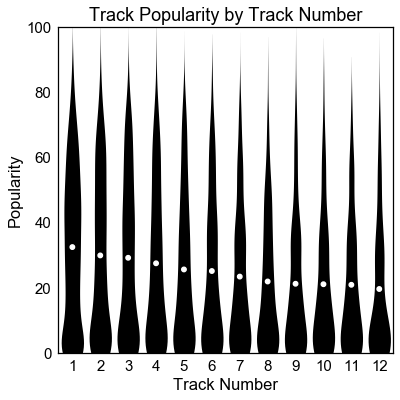

In [13]:
#Plot violins and points, like in decade_violinplot
p = sns.violinplot(x='track_number', y='popularity', 
                   data=df[df.track_number<13], split=False, palette=[(0,0,0)], 
                   saturation=1, scale='width', width=0.8, inner='point', 
                   cut=2, linewidth=0)
p = sns.pointplot(x='track_number', y='popularity', 
                   data=df[df.track_number<13], color='w', join=False, ci=None, 
                  scale=.5)

#Formatting
p.set_ylabel('Popularity')
p.set_xlabel('Track Number')
p.set_ylim([0,100])
title = 'Track Popularity by Track Number'
p.set_title(title);

This downward trend in popularity as an album progresses could be attributed to listeners stopping the album partway through. It could also be partially due to "front-loading" singles so that they appear early in an album. 

Let's use our `bar_violin` function from the [previous notebook](spotify_3_audio_features.ipynb) to visualize the actual *frequency* of tracks with a given track number, split by dataset.

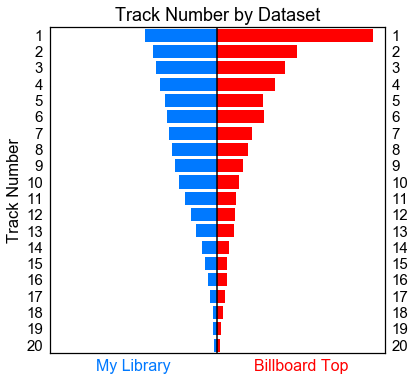

In [14]:
df_temp = df[df.track_number<=20]
p = bar_violin('track_number', df_temp, y_label='Track Number', 
               title='Track Number by Dataset', int_labels=True)

Tracks that appear earlier in an album are more common in *both* datasets. This could again be due to hit tracks appearing earlier in an album, but it may also hint at a similar distribution of *album lengths* (in number of tracks). The Billboard dataset has a sharp peak at 1, indicating that a large fraction of top hits appear as the *first track on an album*. This is unsurprising since historically, hits were usually released as *physical [singles](https://en.wikipedia.org/wiki/Single_(music%29)*.

# End

Now that we've thoroughly explored our datasets' features, we can move on to the *next* phase of our project where we **build a classifier** and use it as a **recommender system**!

[Part 5: Classifier and Recommender](spotify_5_classifier_and_recommender.ipynb)

---

< [Part 3: Audio Features](spotify_3_audio_features.ipynb) | [Main](index.ipynb) | [Part 5: Classifier and Recommender](spotify_5_classifier_and_recommender.ipynb) >